## 14 Evaluate Fitting Parameters
Each model is evaluated on how well it's able to predict the fitting parameters compared to the experimental values.

In [2]:
import pandas as pd
import numpy as np
import pyxrfmaps as px 
import matplotlib.pyplot as plt
import pickle
import xgboost
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

In [3]:
spectra = pd.read_csv('./training_data/08_test_int_spectra.csv', header=None)
fit_params_standard = pd.read_csv('./training_data/07_test_fit_params_standard.csv')
fit_params_constant = pd.read_csv('./training_data/04_fit_params_constant.csv')

In [4]:
fit_params_to_predict = fit_params_standard.drop(columns=fit_params_constant.columns)

In [5]:
print(len(spectra))
print(len(fit_params_to_predict))

6650
6650


In [7]:
#Load the models
xgb_model = pickle.load(open('13_xgboost.sav', 'rb'))
mlp_model = pickle.load(open('13_multilayer_perceptron.sav', 'rb'))
rf_model = pickle.load(open('13_random_forest.sav', 'rb'))

In [8]:
#Predict the fitting parameters
xgb_fit_params_predicted = xgb_model.predict(spectra)
mlp_fit_params_predicted = mlp_model.predict(spectra)
rf_fit_params_predicted = rf_model.predict(spectra)

In [9]:
xgb_predicted_df = pd.DataFrame(xgb_fit_params_predicted, columns=fit_params_to_predict.columns)
mlp_predicted_df = pd.DataFrame(mlp_fit_params_predicted, columns=fit_params_to_predict.columns)
rf_predicted_df = pd.DataFrame(rf_fit_params_predicted, columns=fit_params_to_predict.columns)

In [10]:
#Limit SI_ESCAPE_ENABLE to 0 or 1
for df in [xgb_predicted_df, mlp_predicted_df, rf_predicted_df]:
    df['SI_ESCAPE_ENABLE'] = np.where(df['SI_ESCAPE_ENABLE'] < 0.5, 0.0, 1.0)

In [11]:
#Score the models
xgb_r2_scores = []
mlp_r2_scores = []
rf_r2_scores = []
xgb_spear_scores = []
mlp_spear_scores = []
rf_spear_scores = []
for column in fit_params_to_predict.columns:
    expected = fit_params_to_predict[column]
    predicted = xgb_predicted_df[column]
    score = r2_score(expected, predicted) 
    xgb_r2_scores.append(score if score >= 0 else 0)
    score = spearmanr(expected, predicted).statistic
    xgb_spear_scores.append(score if score >= 0 else 0)

    predicted = mlp_predicted_df[column]
    score = r2_score(expected, predicted)
    mlp_r2_scores.append(score if score >= 0 else 0)
    score = spearmanr(expected, predicted).statistic
    mlp_spear_scores.append(score if score >= 0 else 0)

    predicted = rf_predicted_df[column]
    score = r2_score(expected, predicted)
    rf_r2_scores.append(score if score >= 0 else 0)
    score = spearmanr(expected, predicted).statistic
    rf_spear_scores.append(score if score >= 0 else 0)

C:\Users\user2ide\Miniconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [12]:
#Count how many experiments had good scores for each model
ct = 0
for i in range(len(xgb_r2_scores)):
    if xgb_r2_scores[i] > 0.8:
        ct += 1
print(f"XGB R2 accurate predictions: {ct}")

ct = 0
for i in range(len(mlp_r2_scores)):
    if mlp_r2_scores[i] > 0.8:
        ct += 1
print(f"MLP R2 accurate predictions: {ct}")

ct = 0
for i in range(len(rf_r2_scores)):
    if rf_r2_scores[i] > 0.8:
        ct += 1
print(f"RF R2 accurate predictions: {ct}")

ct = 0
for i in range(len(xgb_spear_scores)):
    if xgb_spear_scores[i] > 0.8:
        ct += 1
print(f"XGB spear accurate predictions: {ct}")

ct = 0
for i in range(len(mlp_spear_scores)):
    if mlp_spear_scores[i] > 0.8:
        ct += 1 
print(f"MLP spear accurate predictions: {ct}")

ct = 0
for i in range(len(rf_spear_scores)):
    if rf_spear_scores[i] > 0.8:
        ct += 1
print(f"RF spear accurate predictions: {ct}")


ct = 0
for i in range(len(xgb_spear_scores)):
    if xgb_spear_scores[i] > 0.8 and xgb_r2_scores[i] > 0.8:
        ct += 1
print(f"XGB both accurate predictions: {ct}")

ct = 0
for i in range(len(mlp_spear_scores)):
    if mlp_spear_scores[i] > 0.8 and mlp_r2_scores[i] > 0.8:
        ct += 1 
print(f"MLP both accurate predictions: {ct}")

ct = 0
for i in range(len(rf_spear_scores)):
    if rf_spear_scores[i] > 0.8 and rf_r2_scores[i] > 0.8:
        ct += 1
print(f"RF both accurate predictions: {ct}")

XGB R2 accurate predictions: 13
MLP R2 accurate predictions: 1
RF R2 accurate predictions: 15
XGB spear accurate predictions: 8
MLP spear accurate predictions: 1
RF spear accurate predictions: 9
XGB both accurate predictions: 7
MLP both accurate predictions: 1
RF both accurate predictions: 8


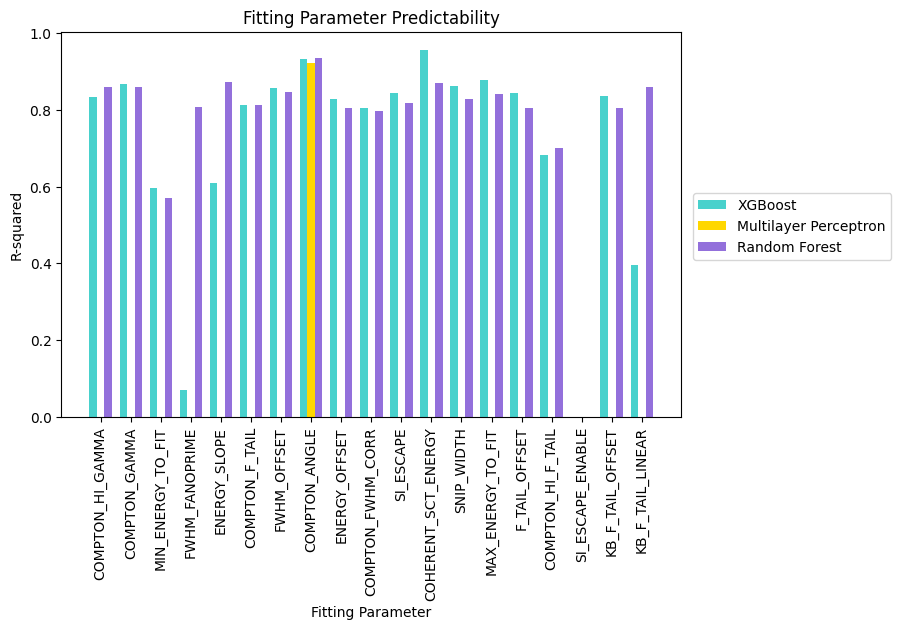

In [13]:
plt.figure(figsize=(8, 5))
bar_width = 0.25

bar_positions1 = np.arange(len(fit_params_to_predict.columns))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions1 + 2 * bar_width

plt.bar(bar_positions1, xgb_r2_scores, width=bar_width, color='mediumturquoise', label='XGBoost')
plt.bar(bar_positions2, mlp_r2_scores, width=bar_width, color='gold', label='Multilayer Perceptron')
plt.bar(bar_positions3, rf_r2_scores, width=bar_width, color='mediumpurple', label='Random Forest')

plt.xticks(bar_positions2, fit_params_to_predict.columns, rotation=90)  

plt.xlabel('Fitting Parameter')
plt.ylabel('R-squared')
plt.title('Fitting Parameter Predictability')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 0.6))
plt.savefig("paramR2.png", bbox_inches='tight')
plt.show()

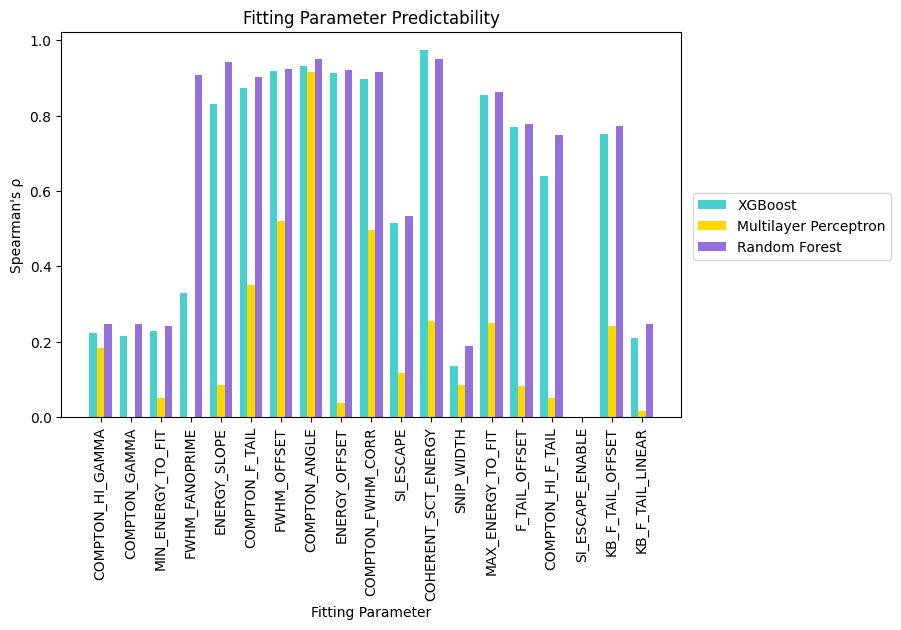

In [14]:
plt.figure(figsize=(8, 5))
bar_width = 0.25

bar_positions1 = np.arange(len(fit_params_to_predict.columns))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions1 + 2 * bar_width

plt.bar(bar_positions1, xgb_spear_scores, width=bar_width, color='mediumturquoise', label='XGBoost')
plt.bar(bar_positions2, mlp_spear_scores, width=bar_width, color='gold', label='Multilayer Perceptron')
plt.bar(bar_positions3, rf_spear_scores, width=bar_width, color='mediumpurple', label='Random Forest')

plt.xticks(bar_positions2, fit_params_to_predict.columns, rotation=90)  

plt.xlabel('Fitting Parameter')
plt.ylabel("Spearman's ρ")
plt.title('Fitting Parameter Predictability')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 0.6))
plt.savefig("paramSpear.png", bbox_inches='tight')
plt.show()